# Table of Contents

* [kNN](#chapter1)
    * [Model Tuning](#section_1_1)
    * [Decision Boundary Plot](#section_1_2)
    * [Decision Boundary k=10](#section_1_3)
    * [ROC Curve](#section_1_4)
    
* [Decision Trees](#chapter2)
    * [Model comparison: Housing Data](#section_2_1)
    
* [Random Forest](#chapter3)
    * [Cross Validation](#section_3_1)
    
* [Gradient Boosting](#chapter4)
    * [Tuning Learning Rate](#section_4_1)
    
* [Comparison of Methods I (California Housing Data)](#chapter5)

* [Comparison of Methods II (Telco Data)](#chapter6)

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools as itt

In [3]:
data_path = r'data/classical_machine_learning'

# 1. k-Nearest Neighbours <a class="anchor" id="chapter1"></a>

In [3]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [4]:
# data

file = 'gender_cleaned_test_train.xlsx'
file_path = os.path.join(data_path, file)

df_train = pd.read_excel(file_path, 'train')
df_test = pd.read_excel(file_path, 'test')

X_train = df_train[['Height', 'Weight']]
y_train = df_train['IsHealthy']

X_test = df_test[['Height', 'Weight']]
y_test = df_test['IsHealthy']

In [5]:
# model

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

model = KNeighborsClassifier()
model.fit(X_train_norm, y_train)

y_hat_test = model.predict(X_test_norm)
y_hatp_test = model.predict_proba(X_test_norm)[:,1]

print(accuracy_score(y_test, y_hat_test))

0.985014985014985


In [6]:
# other approach

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), KNeighborsClassifier())
model.fit(X_train, y_train)

y_hat_test = model.predict(X_test)
y_hatp_test = model.predict_proba(X_test)[:,1]

print(accuracy_score(y_test, y_hat_test))

0.985014985014985


## Simple model tuning <a class="anchor" id="section_1_1"></a>

In [7]:
results = {}

for k in tqdm(range(1,50)):
    
    model = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
    model.fit(X_train, y_train)

    y_hat_test = model.predict(X_test)
    acc = accuracy_score(y_test, y_hat_test)

    results[k] = acc

100%|██████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 26.29it/s]


Text(0.5, 1.0, 'Test set accuracy vs. K')

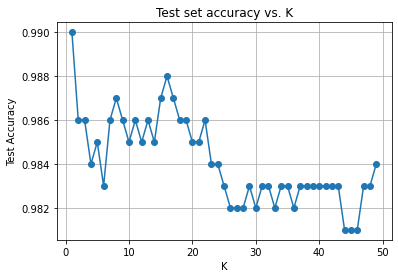

In [8]:
fig, ax = plt.subplots()
ax.plot(list(results.keys()), list(results.values()), marker='o')
ax.grid()
ax.set_xlabel('K')
ax.set_ylabel('Test Accuracy')
plt.title('Test set accuracy vs. K')

## Decision Boundary Plot<a class="anchor" id="section_1_2"></a>

C:\Users\Dell5520\PycharmProjects\personal\machine_learning\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


(-3.3894830736823476, 2.6105169263176524)

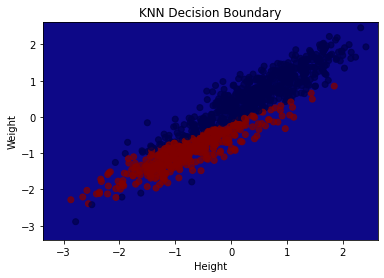

In [20]:
h = 1 #mesh step size

x_min, x_max = X_test_norm[:,0].min() - .5, X_test_norm[:,0].max() + .5
y_min, y_max = X_test_norm[:,1].min() - .5, X_test_norm[:,1].max() + .5
#plot limits

xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h), 
    np.arange(y_min, y_max, h)
)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)


fig, ax = plt.subplots()
#plt.set_cmap('plasma')
ax.pcolormesh(xx, yy, Z)
ax.scatter(
    X_test_norm[:,0], 
    X_test_norm[:,1],
    c=y_test, 
    cmap='seismic',
    alpha=0.75
)
ax.set_xlabel('Height')
ax.set_ylabel('Weight')
ax.set_title('KNN Decision Boundary')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())

## Decision Boundary k=10<a class="anchor" id="section_1_3"></a>

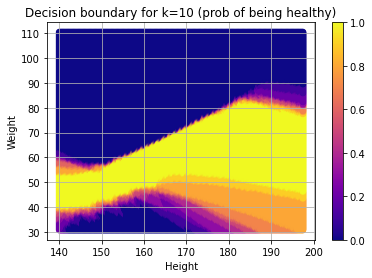

In [11]:
k = 10
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_train, y_train)

grid_points = 200
weight_range = np.linspace(
    X_test.iloc[:,1].min() - .5, 
    X_test.iloc[:,1].max() + .5, 
    grid_points
)
height_range = np.linspace(
    X_test.iloc[:,0].min() - .5, 
    X_test.iloc[:,0].max() + .5, 
    grid_points
)

grid = list(itt.product(height_range, weight_range))
#this is our mesh grid, list of coordinate points

dummy_dat = pd.DataFrame(grid, columns=['Height','Weight'])
dummy_dat['ProbIsHealthy'] = model.predict_proba(dummy_dat)[:,1]

fig, ax = plt.subplots()
scat = ax.scatter(
    dummy_dat.iloc[:,0], 
    dummy_dat.iloc[:,1], 
    c=dummy_dat.iloc[:,2], 
    cmap='plasma'
)
ax.set_xlabel('Height')
ax.set_ylabel('Weight')
ax.set_title(f'Decision boundary for k={k} (prob of being healthy)')
ax.grid()
plt.colorbar(scat, ax=ax)

## ROC Curve<a class="anchor" id="section_1_4"></a>

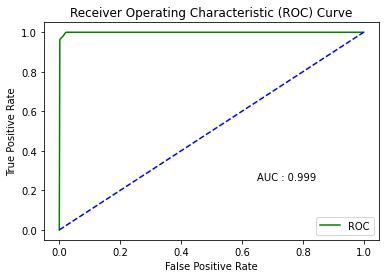

In [10]:
def plot_roc_curve(fper, tper, auc):
    fig, ax = plt.subplots()
    plt.plot(fper, tper, color='green', label='ROC')
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.text(0.65, 0.25,f'AUC : {auc}')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
fper, tper, thresh = roc_curve(y_test, y_hatp_test) 
auc = round(roc_auc_score(y_test, y_hatp_test), 3)

plot_roc_curve(fper, tper, auc)

# 2. Decision Trees<a class="anchor" id="chapter2"></a>

In [21]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.tree import export_text
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler

In [23]:
# data

file = 'gender_cleaned_test_train.xlsx'
file_path = os.path.join(data_path, file)

df_train = pd.read_excel(file_path, 'train')
df_test = pd.read_excel(file_path, 'test')

df_train['BMI'] = df_train['Weight']/((df_train['Height']/100)**2)
df_test['BMI'] = df_test['Weight']/((df_test['Height']/100)**2)

X_train = df_train[['Height', 'Weight']]
y_train = df_train['IsHealthy']

X_test = df_test[['Height', 'Weight']]
y_test = df_test['IsHealthy']

In [25]:
# model

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

y_hat_test = model.predict(X_test)
y_hatp_test = model.predict_proba(X_test)[:,1]

accuracy_score(y_test, y_hat_test)

0.984015984015984

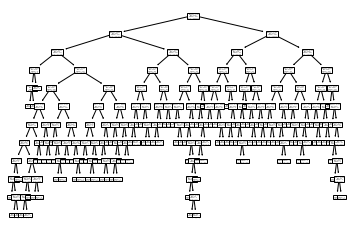

In [27]:
plot_tree(model,feature_names=X_train.columns);
# ; to silence all the text prints

In [28]:
tree_text = export_text(model, feature_names=list(X_train.columns))

print(tree_text)

|--- Weight <= 70.28
|   |--- Weight <= 64.11
|   |   |--- Weight <= 39.57
|   |   |   |--- Height <= 142.35
|   |   |   |   |--- Height <= 140.37
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Height >  140.37
|   |   |   |   |   |--- class: 1
|   |   |   |--- Height >  142.35
|   |   |   |   |--- class: 0
|   |   |--- Weight >  39.57
|   |   |   |--- Weight <= 61.12
|   |   |   |   |--- Height <= 154.90
|   |   |   |   |   |--- Weight <= 58.43
|   |   |   |   |   |   |--- Weight <= 57.18
|   |   |   |   |   |   |   |--- Weight <= 42.42
|   |   |   |   |   |   |   |   |--- Height <= 149.97
|   |   |   |   |   |   |   |   |   |--- Height <= 149.18
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- Height >  149.18
|   |   |   |   |   |   |   |   |   |   |--- Height <= 149.34
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- Height >  149.34
|   |   |   |   |   |   |   |   |   |   | 

## Model comparison: Housing Data<a class="anchor" id="section_2_1"></a>

In [29]:
data = fetch_california_housing()

df = pd.DataFrame(data['data'], columns=data['feature_names'])
df['price'] = data['target']

df_train, df_test = train_test_split(df, test_size=0.2, random_state=99)
df_test = df_test.copy()

X_train = df_train[['Latitude','Longitude']]
y_train = df_train['price']

X_test = df_test[['Latitude','Longitude']]
y_test = df_test['price']

In [35]:
%%time

model = DecisionTreeRegressor()
model.fit(X_train, y_train)

y_hat_test = model.predict(X_test)

mse = mean_squared_error(y_test, y_hat_test)

print(f'Model:\t{type(model).__name__}\nMSE:\t{mse}\n')

model = LinearRegression()
model.fit(X_train, y_train)

y_hat_test = model.predict(X_test)

mse = mean_squared_error(y_test, y_hat_test)

print(f'Model:\t{type(model).__name__}\nMSE:\t{mse}\n')
      
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

model = Ridge()
model.fit(X_train_norm, y_train)
y_hat_test = model.predict(X_test_norm)

mse = mean_squared_error(y_test, y_hat_test)
      
print(f'Model:\t{type(model).__name__}\nMSE:\t{mse}\n')

model = Lasso()
model.fit(X_train_norm, y_train)
y_hat_test = model.predict(X_test_norm)

mse = mean_squared_error(y_test, y_hat_test)

print(f'Model:\t{type(model).__name__}\nMSE:\t{mse}\n')

Model:	DecisionTreeRegressor
MSE:	0.3634784528002139

Model:	LinearRegression
MSE:	0.9797304576845608

Model:	Ridge
MSE:	0.9802356772925531

Model:	Lasso
MSE:	1.2905127283451718

CPU times: total: 78.1 ms
Wall time: 70.5 ms


# 3. Random Forest<a class="anchor" id="chapter3"></a>

In [40]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import GridSearchCV, KFold

In [41]:
# data

data = fetch_california_housing()

df = pd.DataFrame(data['data'], columns=data['feature_names'])
df['price'] = data['target']

df_train, df_test = train_test_split(df, test_size=0.2, random_state=99)
df_test = df_test.copy()

X_train = df_train.drop(['price'], axis=1)
y_train = df_train['price']

X_test = df_test.drop(['price'], axis=1)
y_test = df_test['price']

In [42]:
%%time

# models

mse_train = []
mse_test = []

tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)

y_hat_train = tree_model.predict(X_train)
y_hat_test = tree_model.predict(X_test)

mse_train.append(mean_squared_error(y_train, y_hat_train))
mse_test.append(mean_squared_error(y_test, y_hat_test))

bag_model = BaggingRegressor()
bag_model.fit(X_train, y_train)

y_hat_train = bag_model.predict(X_train)
y_hat_test = bag_model.predict(X_test)

mse_train.append(mean_squared_error(y_train, y_hat_train))
mse_test.append(mean_squared_error(y_test, y_hat_test))

forest_model = RandomForestRegressor()
forest_model.fit(X_train, y_train)

y_hat_train = forest_model.predict(X_train)
y_hat_test = forest_model.predict(X_test)

mse_train.append(mean_squared_error(y_train, y_hat_train))
mse_test.append(mean_squared_error(y_test, y_hat_test))

CPU times: total: 9.98 s
Wall time: 9.98 s


In [43]:
mse_train = pd.Series(mse_train, index=['Tree','Bag','Forest'])
mse_test = pd.Series(mse_test, index=['Tree','Bag','Forest'])

mse_train

Tree      1.008553e-31
Bag       5.331072e-02
Forest    3.622816e-02
dtype: float64

In [44]:
mse_test

Tree      0.474851
Bag       0.275164
Forest    0.245077
dtype: float64

<AxesSubplot:xlabel='feature'>

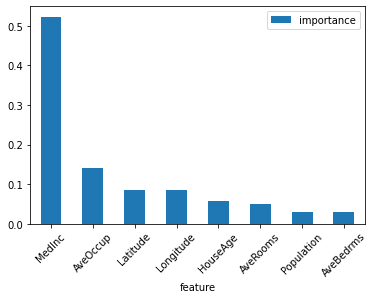

In [48]:
feature_importances_df = pd.DataFrame(
    {
        "feature": list(X_train.columns), 
        "importance": forest_model.feature_importances_
    }
).sort_values("importance", ascending=False)

feature_importances_df.set_index('feature').plot.bar(rot=45)

## Cross-Validation<a class="anchor" id="section_3_1"></a>

In [49]:
# Data Setup

data = fetch_california_housing()

df = pd.DataFrame(data['data'], columns=data['feature_names'])
df['price'] = data['target']
 
# Data Setup - Split

target     = 'price'
predictors = list(set(df.columns) - set([target]))

df['strata'] = pd.qcut(df[target], q=10)

df_train, df_test = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['strata'], 
    random_state=123
)

params_grid = {
    'n_estimators':[5,10,20],
    'max_depth':[2,3,4,5]
}

cv = KFold(n_splits=10, shuffle=True, random_state=123)

cv_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=123),
    param_grid=params_grid,
    cv=cv,
    scoring='neg_mean_squared_error' # A high score is a good thing!    
)

cv_grid.fit(X_train, y_train)

results = cv_grid.cv_results_
df_results = pd.DataFrame(results['params'])
df_results['score'] = results['mean_test_score']

cv_grid.best_params_ #best parameters

{'max_depth': 5, 'n_estimators': 20}

In [52]:
# cross validation results from training data
df_results

,max_depth,n_estimators,score
0,2,5,-0.727450
1,2,10,-0.726425
2,2,20,-0.728122
3,3,5,-0.601237
4,3,10,-0.598196
5,3,20,-0.597418
6,4,5,-0.526997
7,4,10,-0.523705
8,4,20,-0.520522
9,5,5,-0.467498


In [53]:
# test data result

y_hat = cv_grid.best_estimator_.predict(X_test)
mean_squared_error(y_test, y_hat)

0.43846555038380436

In [54]:
# retrain new model with best params - same result

model = RandomForestRegressor(random_state=123, **cv_grid.best_params_)
model.fit(X_train, y_train)

y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

print(f'Training error:\t{mean_squared_error(y_train, y_hat_train)}\n')
print(f'Testing error:\t{mean_squared_error(y_test, y_hat_test)}\n')

Training error:	0.43228475904060154

Testing error:	0.43846555038380436



# 4. Gradient Boosting<a class="anchor" id="chapter4"></a>

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import fetch_california_housing

In [66]:
# data

data = fetch_california_housing()

df = pd.DataFrame(data['data'], columns=data['feature_names'])
df['price'] = data['target']

df_train, df_test = train_test_split(df, test_size=0.2, random_state=99)
df_test = df_test.copy()

X_train = df_train.drop(['price'], axis=1)
y_train = df_train['price']

X_test = df_test.drop(['price'], axis=1)
y_test = df_test['price']

In [67]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

print(f'Training error:\t{mean_squared_error(y_train, y_hat_train)}\n')
print(f'Testing error:\t{mean_squared_error(y_test, y_hat_test)}\n')

Training error:	0.26743551092947476

Testing error:	0.2656471901534154



<AxesSubplot:xlabel='feature'>

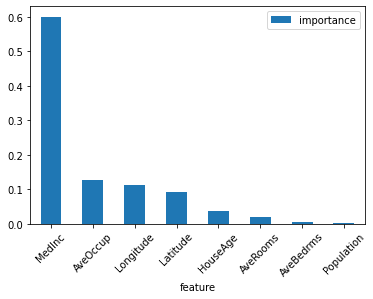

In [69]:
# feature importances

feature_importances_df = pd.DataFrame(
    {"feature": list(X_train.columns), "importance": model.feature_importances_}
).sort_values("importance", ascending=False)

feature_importances_df.set_index('feature').plot.bar(rot=45)

## Tuning Learning Rate<a class="anchor" id="section_4_1"></a>

In [73]:
lr_list = np.linspace(0.01,1,10)

mse_train_list = []
mse_test_list = []

for learning_rate in lr_list:
    
    model = GradientBoostingRegressor(learning_rate=learning_rate)
    model.fit(X_train, y_train)
    
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)

    mse_train = mean_squared_error(y_train, y_hat_train)
    mse_test = mean_squared_error(y_test, y_hat_test)
    
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)
    
    print(f"learning rate:  \t{learning_rate}")
    print(f"training error: \t{round(mse_train, 3)}")
    print(f"validation error:\t{round(mse_test, 3)}\n")

learning rate:  	0.01
training error: 	0.658
validation error:	0.63

learning rate:  	0.12
training error: 	0.249
validation error:	0.252

learning rate:  	0.23
training error: 	0.215
validation error:	0.232

learning rate:  	0.34
training error: 	0.193
validation error:	0.226

learning rate:  	0.45
training error: 	0.187
validation error:	0.227

learning rate:  	0.56
training error: 	0.173
validation error:	0.226

learning rate:  	0.67
training error: 	0.167
validation error:	0.23

learning rate:  	0.78
training error: 	0.167
validation error:	0.238

learning rate:  	0.89
training error: 	0.161
validation error:	0.253

learning rate:  	1.0
training error: 	0.166
validation error:	0.254



<AxesSubplot:xlabel='Learning Rate'>

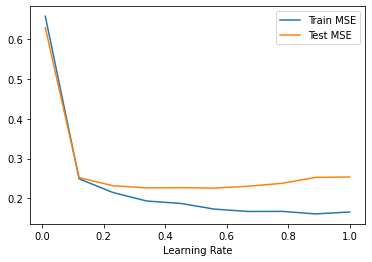

In [74]:
frame = pd.DataFrame(
    {
        'Learning Rate':lr_list,
        'Train MSE': mse_train_list,
        'Test MSE': mse_test_list
    }
)

frame.set_index('Learning Rate').plot()

# 5. Full Comparison of Methods<a class="anchor" id="chapter5"></a>

- We use the california housing data set

In [55]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [56]:
# data

data = fetch_california_housing()

df = pd.DataFrame(data['data'], columns=data['feature_names'])
df['price'] = data['target']

df_train, df_test = train_test_split(df, test_size=0.2, random_state=99)
df_test = df_test.copy()

X_train = df_train.drop(['price'], axis=1)
y_train = df_train['price']

X_test = df_test.drop(['price'], axis=1)
y_test = df_test['price']

In [75]:
%%time

# models

# %%--------------------------------------------------------------------------
# Linear model
# ----------------------------------------------------------------------------

mse_train = []
mse_test = []

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_hat_train = lin_model.predict(X_train)
y_hat_test = lin_model.predict(X_test)

mse_train.append(mean_squared_error(y_train, y_hat_train))
mse_test.append(mean_squared_error(y_test, y_hat_test))

# %%--------------------------------------------------------------------------
# Regularised models
# ----------------------------------------------------------------------------

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

ridge_model = Ridge()
ridge_model.fit(X_train_norm, y_train)
y_hat_train = ridge_model.predict(X_train_norm)
y_hat_test = ridge_model.predict(X_test_norm)

mse_train.append(mean_squared_error(y_train, y_hat_train))
mse_test.append(mean_squared_error(y_test, y_hat_test))

lasso_model = Lasso()
lasso_model.fit(X_train_norm, y_train)
y_hat_train = lasso_model.predict(X_train_norm)
y_hat_test = lasso_model.predict(X_test_norm)

mse_train.append(mean_squared_error(y_train, y_hat_train))
mse_test.append(mean_squared_error(y_test, y_hat_test))

# %%--------------------------------------------------------------------------
# Non-parametric models
# ----------------------------------------------------------------------------

knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)
y_hat_train = knn_model.predict(X_train)
y_hat_test = knn_model.predict(X_test)

mse_train.append(mean_squared_error(y_train, y_hat_train))
mse_test.append(mean_squared_error(y_test, y_hat_test))

tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
y_hat_train = tree_model.predict(X_train)
y_hat_test = tree_model.predict(X_test)

mse_train.append(mean_squared_error(y_train, y_hat_train))
mse_test.append(mean_squared_error(y_test, y_hat_test))

bag_model = BaggingRegressor()
bag_model.fit(X_train, y_train)

y_hat_train = bag_model.predict(X_train)
y_hat_test = bag_model.predict(X_test)

mse_train.append(mean_squared_error(y_train, y_hat_train))
mse_test.append(mean_squared_error(y_test, y_hat_test))

forest_model = RandomForestRegressor()
forest_model.fit(X_train, y_train)

y_hat_train = forest_model.predict(X_train)
y_hat_test = forest_model.predict(X_test)

mse_train.append(mean_squared_error(y_train, y_hat_train))
mse_test.append(mean_squared_error(y_test, y_hat_test))

model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

mse_train.append(mean_squared_error(y_train, y_hat_train))
mse_test.append(mean_squared_error(y_test, y_hat_test))

CPU times: total: 13.4 s
Wall time: 13.4 s


In [77]:
pd.DataFrame(
    list(zip(mse_train, mse_test)),
    columns = ['train_mse', 'test_mse'],
    index=['linear','ridge','lasso','knn','tree', 'bag', 'forest', 'boost']
).sort_values(by='test_mse')

,train_mse,test_mse
forest,3.619415e-02,0.243658
boost,2.674355e-01,0.265618
bag,5.161270e-02,0.267608
tree,9.206468e-32,0.477973
ridge,5.306401e-01,0.485589
linear,5.306400e-01,0.499820
knn,7.323567e-01,1.129081
lasso,1.341848e+00,1.290513


# 6. Comparison of Methods II<a class="anchor" id="chapter6"></a>

Here we are using Telco data from Kaggle

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [19]:
file_path_train = os.path.join(data_path, 'churnTrain.csv')
file_path_test = os.path.join(data_path, 'churnTest.csv')

df_train = pd.read_csv(file_path_train)
df_test = pd.read_csv(file_path_test)

In [20]:
# Rows containing NULLs

print(f"Rows from train data with NULLs: {len(df_train[df_train.isnull().any(axis=1)])}")
print(f"Rows from test data with NULLs: {len(df_test[df_test.isnull().any(axis=1)])}")

# Drop rows with NULLs from dataset

df_test_dropped = df_test.dropna(axis=0) # drop these rows - likely a better way of dealing with this
print(f"Rows from test data with NULLs: {len(df_test_dropped[df_test_dropped.isnull().any(axis=1)])}")

Rows from train data with NULLs: 0
Rows from test data with NULLs: 64
Rows from test data with NULLs: 0


In [21]:
# Dataset columns

print(f"Train data columns:\n{list(df_train.columns)}\n")
print(f"Test data columns:\n{list(df_test.columns)}") # no churn column

Train data columns:
['State', 'Account_Length', 'Area_Code', 'Phone_No', 'International_Plan', 'Voice_Mail_Plan', 'No_Vmail_Messages', 'Total_Day_minutes', 'Total_Day_Calls', 'Total_Day_charge', 'Total_Eve_Minutes', 'Total_Eve_Calls', 'Total_Eve_Charge', 'Total_Night_Minutes', 'Total_Night_Calls', 'Total_Night_Charge', 'Total_Intl_Minutes', 'Total_Intl_Calls', 'Total_Intl_Charge', 'No_CS_Calls', 'Churn']

Test data columns:
['State', 'Account_Length', 'Area_Code', 'Phone_No', 'International_Plan', 'Voice_Mail_Plan', 'No_Vmail_Messages', 'Total_Day_minutes', 'Total_Day_Calls', 'Total_Day_charge', 'Total_Eve_Minutes', 'Total_Eve_Calls', 'Total_Eve_Charge', 'Total_Night_Minutes', 'Total_Night_Calls', 'Total_Night_Charge', 'Total_Intl_Minutes', 'Total_Intl_Calls', 'Total_Intl_Charge', 'No_CS_Calls']


In [22]:
# prepare modelling datasets

df_train = df_train.copy()
df_test_dropped = df_test_dropped.copy()

df_train.replace((' no', ' yes'), (0, 1), inplace=True) #there is whitespace infront
df_test_dropped.replace((' no', ' yes'), (0, 1), inplace=True) 

df_train.replace((False, True), (0, 1), inplace=True) 

df_train['State'] = df_train['State'].astype('category')
df_train['State'] = df_train['State'].cat.codes
df_train['Area_Code'] = df_train['Area_Code'].astype('category')
df_train['Area_Code'] = df_train['Area_Code'].cat.codes

#do this for test set in real times

df_train, df_valid = train_test_split(df_train, test_size=0.2, stratify=df_train['State'], random_state=99)
df_valid = df_valid.copy()

X_train = df_train.drop(['Churn'], axis=1)
y_train = df_train['Churn']

X_valid= df_valid.drop(['Churn'], axis=1)
y_valid = df_valid['Churn']

X_test = df_test

In [25]:
# modelling - logistic

log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_hat_train = log_model.predict(X_train)
y_hat_valid = log_model.predict(X_valid)

print(f'Training accuracy:\t{accuracy_score(y_train, y_hat_train)}')
print(f'Validation accuracy:\t{accuracy_score(y_valid, y_hat_valid)}')

Training accuracy:	0.8525881470367592
Validation accuracy:	0.8650674662668666


In [26]:
# modelling - knn

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_valid_norm = scaler.fit_transform(X_valid)

knn_model = KNeighborsClassifier()
knn_model.fit(X_train_norm, y_train)

y_hat_train = knn_model.predict(X_train_norm)
y_hat_valid = knn_model.predict(X_valid_norm)

print(f'Training accuracy:\t{accuracy_score(y_train, y_hat_train)}')
print(f'Validation accuracy:\t{accuracy_score(y_valid, y_hat_valid)}')

Training accuracy:	0.9171042760690172
Validation accuracy:	0.9070464767616192


In [27]:
# modelling - tree

tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

y_hat_train = tree_model.predict(X_train)
y_hat_valid = tree_model.predict(X_valid)

print(f'Training accuracy:\t{accuracy_score(y_train, y_hat_train)}')
print(f'Validation accuracy:\t{accuracy_score(y_valid, y_hat_valid)}')

Training accuracy:	1.0
Validation accuracy:	0.9070464767616192


In [28]:
# modelling - bag

bag_model = BaggingClassifier()
bag_model.fit(X_train, y_train)

y_hat_train = bag_model.predict(X_train)
y_hat_valid = bag_model.predict(X_valid)

print(f'Training accuracy:\t{accuracy_score(y_train, y_hat_train)}')
print(f'Validation accuracy:\t{accuracy_score(y_valid, y_hat_valid)}')

Training accuracy:	0.9913728432108027
Validation accuracy:	0.9625187406296851


In [29]:
# modelling - forest

forest_model = RandomForestClassifier()
forest_model.fit(X_train, y_train)

y_hat_train = forest_model.predict(X_train)
y_hat_valid = forest_model.predict(X_valid)

print(f'Training accuracy:\t{accuracy_score(y_train, y_hat_train)}')
print(f'Validation accuracy:\t{accuracy_score(y_valid, y_hat_valid)}')

Training accuracy:	1.0
Validation accuracy:	0.9625187406296851


In [30]:
# modelling - boost

boost_model = GradientBoostingClassifier()
boost_model.fit(X_train, y_train)

y_hat_train = boost_model.predict(X_train)
y_hat_valid = boost_model.predict(X_valid)

print(f'Training accuracy:\t{accuracy_score(y_train, y_hat_train)}')
print(f'Validation accuracy:\t{accuracy_score(y_valid, y_hat_valid)}')

Training accuracy:	0.9737434358589647
Validation accuracy:	0.9565217391304348
